References
* https://www.kaggle.com/artgor/eda-and-models
* https://www.kaggle.com/robikscube/ieee-fraud-detection-first-look-and-eda

Importing libraries

In [2]:
import sys
sys.path.append('/tmp/working/IEEE_Fraud_Detection/')

import numpy as np
import pandas as pd
import os
from functions.functions import load_datasets

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn import metrics
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import json

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')
color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

In [13]:
%%time
train, test = load_datasets(["user_id"])

CPU times: user 1.05 s, sys: 490 ms, total: 1.54 s
Wall time: 2.57 s


In [15]:
train.head()

,uid,uid2,uid3,uid4,uid5,uid_fq_enc,uid2_fq_enc,uid3_fq_enc,uid4_fq_enc,uid5_fq_enc
0,13926.0_nan,13926.0_nan_150.0_142.0,13926.0_nan_150.0_142.0_315.0_87.0,13926.0_nan_150.0_142.0_315.0_87.0_email_not_p...,13926.0_nan_150.0_142.0_315.0_87.0_email_not_p...,6,6,2,1,2
1,2755.0_404.0,2755.0_404.0_150.0_102.0,2755.0_404.0_150.0_102.0_325.0_87.0,2755.0_404.0_150.0_102.0_325.0_87.0_gmail.com,2755.0_404.0_150.0_102.0_325.0_87.0_email_not_...,1328,1328,105,21,98
2,4663.0_490.0,4663.0_490.0_150.0_166.0,4663.0_490.0_150.0_166.0_330.0_87.0,4663.0_490.0_150.0_166.0_330.0_87.0_outlook.com,4663.0_490.0_150.0_166.0_330.0_87.0_email_not_...,1787,1787,46,4,45
3,18132.0_567.0,18132.0_567.0_150.0_117.0,18132.0_567.0_150.0_117.0_476.0_87.0,18132.0_567.0_150.0_117.0_476.0_87.0_yahoo.com,18132.0_567.0_150.0_117.0_476.0_87.0_email_not...,7602,7602,362,142,354
4,4497.0_514.0,4497.0_514.0_150.0_102.0,4497.0_514.0_150.0_102.0_420.0_87.0,4497.0_514.0_150.0_102.0_420.0_87.0_gmail.com,4497.0_514.0_150.0_102.0_420.0_87.0_email_not_...,30,30,1,1,1


In [27]:
train = train[['isFraud', 'TransactionDT', 'ProductCD', 'TransactionAmt_decimal', 'P_emaildomain', 'R_emaildomain']]
train.dtypes

isFraud                       int8
TransactionDT                int32
ProductCD                 category
TransactionAmt_decimal       int64
P_emaildomain             category
R_emaildomain             category
dtype: object

In [29]:
for col, col_type in train.dtypes.iteritems():
    if col_type == 'int8' or 'int32' or 'int64':
        pass
    else:
        train[col] = train[col].astype('object')
    print(col, col_type)


isFraud int8
TransactionDT int32
ProductCD category
TransactionAmt_decimal int64
P_emaildomain category
R_emaildomain category


In [32]:
train = train[['isFraud', 'TransactionDT', 'ProductCD', 'TransactionAmt_decimal']]

In [33]:
train.head()

,isFraud,TransactionDT,ProductCD,TransactionAmt_decimal
0,0,86400,W,500
1,0,86401,W,0
2,0,86469,W,0
3,0,86499,W,0
4,0,86506,H,0


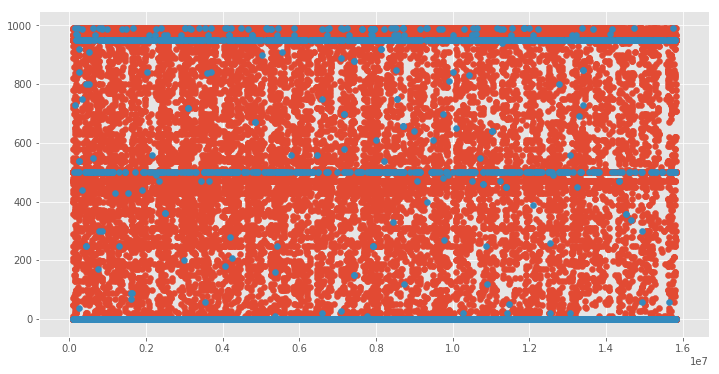

In [37]:
df = train[train.ProductCD=='W'] 
plt.figure(figsize=(12,6))
plt.scatter(df[df.isFraud==0].TransactionDT,df[df.isFraud==0]['TransactionAmt_decimal'])
plt.scatter(df[df.isFraud==1].TransactionDT,df[df.isFraud==1]['TransactionAmt_decimal'])
plt.

In [6]:
train = train[['ProductCD', 'dist1', 'dist2']]

,ProductCD,dist1,dist2
0,W,19.0,NaN
1,W,NaN,NaN
2,W,287.0,NaN
3,W,NaN,NaN
4,H,NaN,NaN


In [7]:
for col in train:
    print(train[col].unique())

['W' 'H' 'C' 'S' 'R']
[  19.   nan  287. ... 4851. 2042. 4728.]
[  nan   30.   98. ... 1467. 1172. 2296.]


In [61]:
one_value_cols = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols

[]

In [37]:
pd.set_option('display.max_columns', None)	
i_cols = ['D'+str(i) for i in range(1,16)]
train[i_cols].head()

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0
1,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0
2,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0
3,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0
4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
train[i_cols].head(30)

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0
1,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0
2,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0
3,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0
4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0
6,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0
7,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0
8,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,61.0,61.0,30.0,318.0,30.0,NaN,NaN,NaN,NaN,40.0,302.0,NaN,NaN,NaN,318.0


In [11]:
train['DT_M'].unique()

array([12, 13, 14, 15, 16, 17])

In [12]:
test['DT_M'].unique()

array([19, 20, 21, 22, 23, 24])

In [37]:
train[['M1','M2','M3','M5','M6','M7','M8','M9','M4']].head(10)

,M1,M2,M3,M5,M6,M7,M8,M9,M4
0,T,T,T,F,T,None,None,None,M2
1,None,None,None,T,T,None,None,None,M0
2,T,T,T,F,F,F,F,F,M0
3,None,None,None,T,F,None,None,None,M0
4,None,None,None,None,None,None,None,None,None
5,T,T,T,F,T,None,None,None,M1
6,T,T,T,F,F,T,T,T,M0
7,None,None,None,F,F,None,None,None,M0
8,None,None,None,None,None,None,None,None,None
9,T,T,T,T,T,None,None,None,M0


In [38]:
for col in ['M1','M2','M3','M5','M6','M7','M8','M9']:
    train[col] = train[col].map({'T':1, 'F':0})
    test[col]  = test[col].map({'T':1, 'F':0})

for col in ['M4']:
    print('Encoding', col)
    temp = pd.concat([train[[col]], test[[col]]])
    col_encoded = temp[col].value_counts().to_dict()   
    train[col] = train[col].map(col_encoded)
    test[col]  = test[col].map(col_encoded)
    print(col_encoded)

Encoding M4
{'M0': 357789, 'M2': 122947, 'M1': 97306}


In [39]:
train[['M1','M2','M3','M5','M6','M7','M8','M9','M4']].head(10)

,M1,M2,M3,M5,M6,M7,M8,M9,M4
0,1.0,1.0,1.0,0.0,1.0,NaN,NaN,NaN,122947.0
1,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,357789.0
2,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,357789.0
3,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,357789.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1.0,1.0,1.0,0.0,1.0,NaN,NaN,NaN,97306.0
6,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,357789.0
7,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,357789.0
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,357789.0


In [40]:
i_cols = ['M1','M2','M3','M5','M6','M7','M8','M9']
train['M_sum'] = train[i_cols].sum(axis=1).astype(np.int8)
test['M_sum']  = test[i_cols].sum(axis=1).astype(np.int8)
train['M_na'] = train[i_cols].isna().sum(axis=1).astype(np.int8)
test['M_na']  = test[i_cols].isna().sum(axis=1).astype(np.int8)

In [42]:
gc.collect()

7147

In [47]:
train['TransactionAmt'].head(20)

0      68.500000000000000
1      29.000000000000000
2      59.000000000000000
3      50.000000000000000
4      50.000000000000000
5      49.000000000000000
6     159.000000000000000
7     422.500000000000000
8      15.000000000000000
9     117.000000000000000
10     75.887000000000000
11     16.495000000000001
12     50.000000000000000
13     40.000000000000000
14     10.500000000000000
15     57.950000000000003
16     30.000000000000000
17    100.000000000000000
18     47.950000000000003
19    186.000000000000000
Name: TransactionAmt, dtype: float64

In [5]:
train, test = load_datasets(['count_encoding_both4'])

In [6]:
one_value_cols = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]
cols_to_drop = list(set(one_value_cols+ one_value_cols_test))

In [12]:
for col in test.columns:
    print(train[col].nunique())

45
15
24
16
76
89
62
70
27
37
89
42
24
60
17
179
147
51
15
12
50
53
71
107
5
104
3


In [8]:
col = 'M_sum'
le = LabelEncoder()
le.fit(list(train_m[col].astype(str).values) + list(test_m[col].astype(str).values))
train_m[col] = le.transform(list(train_m[col].astype(str).values))
test_m[col] = le.transform(list(test_m[col].astype(str).values))

In [14]:
train_m['M_sum'].nunique()

1

In [4]:
train[['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14']].isnull().sum()

C1     0
C2     0
C3     0
C4     0
C5     0
C6     0
C7     0
C8     0
C9     0
C10    0
C11    0
C12    0
C13    0
C14    0
dtype: int64

TypeError: loop of ufunc does not support argument 0 of type str which has no callable log method

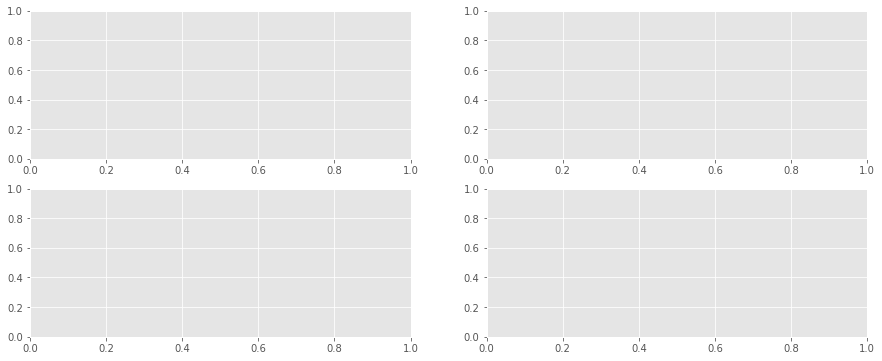

In [24]:
col = 'ProductCD'
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 6))
train.loc[train['isFraud'] == 1] \
    [col].apply(np.log) \
    .plot(kind='hist',
          bins=100,
          title=('Log {} - Fraud').format(col),
          color=color_pal[1],
          xlim=(-3, 10),
         ax= ax1)
train.loc[train['isFraud'] == 0] \
    [col].apply(np.log) \
    .plot(kind='hist',
          bins=100,
          title=('Log {} - Not Fraud').format(col),
          color=color_pal[2],
          xlim=(-3, 10),
         ax=ax2)

train.loc[train['isFraud'] == 1] \
    [col] \
    .plot(kind='hist',
          bins=100,
          title=('{} - Fraud').format(col),
          color=color_pal[1],
         ax= ax3)
train.loc[train['isFraud'] == 0] \
    [col] \
    .plot(kind='hist',
          bins=100,
          title=('{}  - Not Fraud').format(col),
          color=color_pal[2],
         ax=ax4)

plt.show()

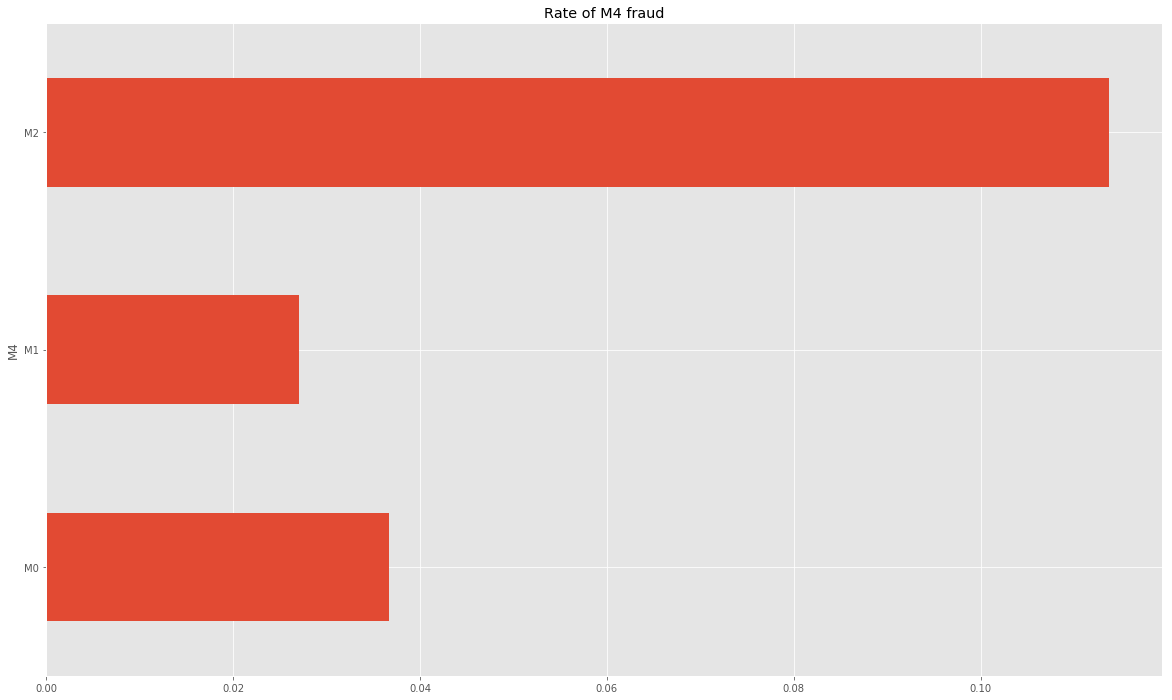

In [26]:
col = 'M4'
fig, ax = plt.subplots(1, 1, figsize=(20, 12))
(train.loc[train['isFraud'] == 1].groupby(col)[col].count()/(train.loc[train['isFraud'] == 1].groupby(col)[col].count() + train.loc[train['isFraud'] == 0].groupby(col)[col].count())).plot(kind='barh', ax=ax, title='Rate of ' + col + ' fraud')
plt.show()    

## Data loading and overview

Data is separated into two datasets: information about the identity of the customer and transaction information. Not all transactions belong to identities, which are available. Maybe it would be possible to use additional transactions to generate new features.

In [3]:
folder_path = '/tmp/working/IEEE_Fraud_Detection/data/input/'
train_identity = pd.read_csv(f'{folder_path}train_identity.csv')
train_transaction = pd.read_csv(f'{folder_path}train_transaction.csv')
test_identity = pd.read_csv(f'{folder_path}test_identity.csv')
test_transaction = pd.read_csv(f'{folder_path}test_transaction.csv')
sub = pd.read_csv(f'{folder_path}sample_submission.csv')
#let's combine the data and work with the whole dataset
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

In [4]:
print(f'Train dataset has {train.shape[0]} rows and {train.shape[1]} columns.')
print(f'Test dataset has {test.shape[0]} rows and {test.shape[1]} columns.')

Train dataset has 590540 rows and 434 columns.
Test dataset has 506691 rows and 433 columns.


So we have two medium-sized datasets with a lot of columns. Train and test data have similar number of rows

In [5]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [7]:
del train_identity, train_transaction, test_identity, test_transaction
gc.collect()

235

In [8]:
print(f'There are {train.isnull().any().sum()} columns in train dataset with missing values.')

There are 414 columns in train dataset with missing values.


In [9]:
print('  {:.4f}% of Transactions that are fraud in train '.format(train['isFraud'].mean() * 100))

  3.4990% of Transactions that are fraud in train 


In [10]:
train.shape, train.dtypes.unique()

((590540, 434),
 array([dtype('int64'), dtype('float64'), dtype('O')], dtype=object))

In [16]:
train['id_23'].unique()

array([nan, 'IP_PROXY:TRANSPARENT', 'IP_PROXY:ANONYMOUS',
       'IP_PROXY:HIDDEN'], dtype=object)

In [22]:
cat_cols = ['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29',
            'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'ProductCD', 'card4', 'card6', 'M4','P_emaildomain',
            'R_emaildomain', 'card1', 'card2', 'card3',  'card5', 'addr1', 'addr2', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9', 'P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3', 'R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']

In [54]:
train['card1'].head()

0    13926
1     2755
2     4663
3    18132
4     4497
Name: card1, dtype: int64

In [53]:
train.select_dtypes(include=int).columns.values

array(['TransactionID', 'isFraud', 'TransactionDT', 'card1', 'had_id',
       'number_of_null'], dtype=object)

In [23]:
cat_cols2 = train.select_dtypes(include=object).columns.values

In [25]:
set(cat_cols) - set(cat_cols2)

{'addr1',
 'addr2',
 'card1',
 'card2',
 'card3',
 'card5',
 'id_13',
 'id_14',
 'id_17',
 'id_18',
 'id_19',
 'id_20',
 'id_21',
 'id_22',
 'id_24',
 'id_25',
 'id_26',
 'id_32'}

In [26]:
set(cat_cols2) - set(cat_cols)

{'OS_id_30',
 'browser_id_31',
 'device_name',
 'device_version',
 'screen_height',
 'screen_width',
 'version_id_30',
 'version_id_31'}

In [35]:
train['id_19'].head(20)

0       NaN
1       NaN
2       NaN
3       NaN
4     542.0
5       NaN
6       NaN
7       NaN
8     621.0
9       NaN
10    410.0
11    176.0
12      NaN
13      NaN
14      NaN
15      NaN
16    529.0
17    529.0
18      NaN
19      NaN
Name: id_19, dtype: float64

In [38]:
train['screen_height'] = train['screen_height'].astype(float)

In [39]:
train['screen_height'].head()

0       NaN
1       NaN
2       NaN
3       NaN
4    1080.0
Name: screen_height, dtype: float64

In [61]:
train['number_of_null'] = train.isnull().sum(axis=1)
train['number_of_null_object'] = train.select_dtypes(include=object).isnull().sum(axis=1)
train['number_of_null_numerical'] = train.select_dtypes(include=float).isnull().sum(axis=1)
train['number_of_null_obj_div_num'] = train['number_of_null_object'] / train['number_of_null_numerical']
train['number_of_null_num_div_obj'] = train['number_of_null_numerical'] / train['number_of_null_object']
train['number_of_null_obj_times_num'] = train['number_of_null_object'] * train['number_of_null_numerical']

In [62]:
train['number_of_null_obj_times_num'] = train['number_of_null_object'] * train['number_of_null_numerical']

In [76]:
many_null_cols = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.5]
train['number_of_null_restricted'] = train.drop(many_null_cols, axis=1).isnull().sum(axis=1)

In [17]:
def id_split(dataframe):
    dataframe['device_name'] = dataframe['DeviceInfo'].str.split('/', expand=True)[0]
    dataframe['device_version'] = dataframe['DeviceInfo'].str.split('/', expand=True)[1]

    dataframe['OS_id_30'] = dataframe['id_30'].str.split(' ', expand=True)[0]
    dataframe['version_id_30'] = dataframe['id_30'].str.split(' ', expand=True)[1]

    dataframe['browser_id_31'] = dataframe['id_31'].str.split(' ', expand=True)[0]
    dataframe['version_id_31'] = dataframe['id_31'].str.split(' ', expand=True)[1]

    dataframe['screen_width'] = dataframe['id_33'].str.split('x', expand=True)[0]
    dataframe['screen_height'] = dataframe['id_33'].str.split('x', expand=True)[1]

    dataframe['id_34'] = dataframe['id_34'].str.split(':', expand=True)[1]
    dataframe['id_23'] = dataframe['id_23'].str.split(':', expand=True)[1]

    dataframe.loc[dataframe['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG'
    dataframe.loc[dataframe['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV'
    dataframe.loc[dataframe['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE'
    dataframe.loc[dataframe['device_name'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE'
    dataframe.loc[dataframe['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux'
    dataframe.loc[dataframe['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony'
    dataframe.loc[dataframe['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC'
    dataframe.loc[dataframe['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'

    dataframe.loc[dataframe.device_name.isin(dataframe.device_name.value_counts()[dataframe.device_name.value_counts() < 200].index), 'device_name'] = "Others"
    dataframe['had_id'] = 1
    gc.collect()
    
    return dataframe

In [18]:
train = id_split(train)
test = id_split(test)

In [19]:
train[['P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3']] = train['P_emaildomain'].str.split('.', expand=True)
train[['R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']] = train['R_emaildomain'].str.split('.', expand=True)

In [ ]:
ax = train.plot(x='TransactionDT',
                       y='TransactionAmt',    # TransactionAmt: 取引金額
                       kind='scatter',
                       alpha=0.01,
                       label='TransactionAmt-train',
                       title='Train and test Transaction Ammounts by Time (TransactionDT)',
                       ylim=(0, 5000),
                       figsize=(15, 5))
test.plot(x='TransactionDT',
          y='TransactionAmt',
          kind='scatter',
          label='TransactionAmt-test',
          alpha=0.01,
          color=color_pal[1],
          ylim=(0, 5000),
          ax=ax)
# Plot Fraud as Orange
train.loc[train['isFraud'] == 1] \
    .plot(x='TransactionDT',
         y='TransactionAmt',
         kind='scatter',
         alpha=0.01,
         label='TransactionAmt-train',
         title='Train and test Transaction Ammounts by Time (TransactionDT)',
         ylim=(0, 5000),
         color='orange',
         figsize=(15, 5),
         ax=ax)
plt.show()

In [ ]:
one_value_cols = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]
one_value_cols == one_value_cols_test

In [ ]:
train['V107'].unique(), test['V107'].unique()

Fraudとなる時の取引金額は低い時が多い？？
'V107' はテストでは値が1つかないので削除

In [ ]:
many_null_cols = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.9]
many_null_cols_test = [col for col in test.columns if test[col].isnull().sum() / test.shape[0] > 0.9]
many_null_cols, many_null_cols_test

reference:https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203#latest-584717  

#### Transaction Table 
* TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
* TransactionAMT: transaction payment amount in USD
* ProductCD: product code, the product for each transaction
* card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
* addr: address
* dist: distance
* P_ and (R__) emaildomain: purchaser and recipient email domain
* C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
* D1-D15: timedelta, such as days between previous transaction, etc.
* M1-M9: match, such as names on card and address, etc.
* Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.
* Categorical Features:
* ProductCD
* card1 - card6
* addr1, addr2
* Pemaildomain Remaildomain
* M1 - M9

#### Identity Table 
Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions. 
They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

* Categorical Features:
* DeviceType
* DeviceInfo
* id12 - id38

## TransactionAmt
TransactionAmt(取引金額)の対数変換を行ってみる。

In [ ]:
train['TransactionAmt'] \
    .apply(np.log) \
    .plot(kind='hist',
          bins=100,
          figsize=(15, 5),
          title='Distribution of Log Transaction Amt')
plt.show()

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 6))
train.loc[train['isFraud'] == 1] \
    ['TransactionAmt'].apply(np.log) \
    .plot(kind='hist',
          bins=100,
          title='Log Transaction Amt - Fraud',
          color=color_pal[1],
          xlim=(-3, 10),
         ax= ax1)
train.loc[train['isFraud'] == 0] \
    ['TransactionAmt'].apply(np.log) \
    .plot(kind='hist',
          bins=100,
          title='Log Transaction Amt - Not Fraud',
          color=color_pal[2],
          xlim=(-3, 10),
         ax=ax2)

train.loc[train['isFraud'] == 1] \
    ['TransactionAmt'] \
    .plot(kind='hist',
          bins=100,
          title='Transaction Amt - Fraud',
          color=color_pal[1],
         ax= ax3)
train.loc[train['isFraud'] == 0] \
    ['TransactionAmt'] \
    .plot(kind='hist',
          bins=100,
          title='Transaction Amt - Not Fraud',
          color=color_pal[2],
         ax=ax4)

plt.show()

In [ ]:
gc.collect()

不正取引された時の金額は平均値が高い様に見える。  
実際に計算してみる

In [ ]:
print('Mean transaction amt for fraud is {:.4f}'
      .format(train.loc[train['isFraud'] == 1]['TransactionAmt'].mean()))
print('Mean transactiom amt for non-fraud is {:.4f}'
     .format(train.loc[train['isFraud'] == 0]['TransactionAmt'].mean()))

## ProductCD
* -ProductCDが何を意味するかはわからない。- → product code, the product for each transcation
* 'W'の頻度が最も高く、'C'の頻度が最も低い。
* 'C'が最もfraud率が高い。
* 'W'が最もfraud率が低い。

In [ ]:
train.groupby('ProductCD')['TransactionID'].count().sort_index()\
        .plot(kind='barh',   # barh:垂直棒グラフ
             figsize=(15,3),
             title='Count of Observations by ProductCD')

plt.show()

In [ ]:
train.groupby('ProductCD')['isFraud'] \
    .mean() \
    .sort_index() \
    .plot(kind='barh',
          figsize=(15, 3),
         title='Percentage of Fraud by ProductCD')
plt.show()

## Categorical Features - Transaction
* ProductCD
* emaildomain
* card1 - card6
* addr1, addr2
* P_emaildomain
* R_emaildomain
* M1 - M9

### card1- card6

In [ ]:
card_cols = [c for c in train.columns if 'card' in c]
train[card_cols].head()

In [ ]:
color_idx = 0
for c in card_cols:
    if train[c].dtype in ['float64','int64']:
        train[c].plot(kind='hist',
                      title=c,
                      bins=50,
                      figsize=(15, 2),
                      color=color_pal[color_idx])
    color_idx += 1
    plt.show()

In [ ]:
train_fr = train.loc[train['isFraud'] == 1]
train_nofr = train.loc[train['isFraud'] == 0]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 8))
train_fr.groupby('card4')['card4'].count().plot(kind='barh', ax=ax1, title='Count of card4 fraud')
train_nofr.groupby('card4')['card4'].count().plot(kind='barh', ax=ax2, title='Count of card4 non-fraud')
train_fr.groupby('card6')['card6'].count().plot(kind='barh', ax=ax3, title='Count of card6 fraud')
train_nofr.groupby('card6')['card6'].count().plot(kind='barh', ax=ax4, title='Count of card6 non-fraud')
plt.show()

In [ ]:
cat_cols = ['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29',
            'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'ProductCD', 'card4', 'card6', 'M4','P_emaildomain',
            'R_emaildomain', 'card1', 'card2', 'card3',  'card5', 'addr1', 'addr2', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9',
            'P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3', 'R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']

In [ ]:
train_fr = train.loc[train['isFraud'] == 1]
train_nofr = train.loc[train['isFraud'] == 0]
for col in train.select_dtypes(include=object).columns.values:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 12))
    train_fr.groupby(col)[col].count().plot(kind='barh', ax=ax1, title='Count of ' + col + ' fraud')
    train_nofr.groupby(col)[col].count().plot(kind='barh', ax=ax2, title='Count of ' + col + ' non-fraud')
    (train_fr.groupby(col)[col].count()/(train_fr.groupby(col)[col].count() + train_nofr.groupby(col)[col].count())).plot(kind='barh', ax=ax3, title='Rate of ' + col + ' fraud')
    plt.show()

## addr1 & addr2
Data discriptionではこれらはカテゴリカル変数だとされているが、数値データの様に見える。
住所？？

In [ ]:
print(' addr1 - has {} Null values'.format(train['addr1'].isna().sum()))
print(' addr2 - has {} Null values'.format(train['addr2'].isna().sum()))

In [ ]:
train['addr2'].unique()

In [ ]:
train['addr1'].plot(kind='hist', bins=500, figsize=(15, 2), title='addr1 distribution')
plt.show()
train['addr2'].plot(kind='hist', bins=500, figsize=(15, 2), title='addr2 distribution')
plt.show()

## dist1 & dist2
横軸は底10の対数を採用した方がわかりやすい。  
この変数はカードを使用した場所とownerの家との距離？？

In [ ]:
train_fr['dist1'].plot(kind='hist',
                            bins=5000,
                            figsize=(15, 2),
                            title='dist1 fraud distribution',
                            color=color_pal[1],
                            logx=True)
plt.show();

train_nofr['dist1'].plot(kind='hist',
                            bins=5000,
                            figsize=(15, 2),
                            title='dist1 no fraid distribution',
                            color=color_pal[2],
                            logx=True)

plt.show()

train_fr['dist2'].plot(kind='hist',
                            bins=5000,
                            figsize=(15, 2),
                            title='dist2 fraud distribution',
                            color=color_pal[1],
                            logx=True)
plt.show()

train_nofr['dist2'].plot(kind='hist',
                            bins=5000,
                            figsize=(15, 2),
                            title='dist2 no fraud distribution',
                            color=color_pal[2],
                            logx=True)
plt.show();

## C1-C14
数値カラムは非常に多い。pairplotを作成する。

In [ ]:
c_cols = [c for c in train if c[0] == 'C']
train[c_cols].head()

In [ ]:
#欠損値の割合を見てみる
for c in c_cols:
    print('{} : {:.2f} % Null values'.format(c, float(train[c].isna().sum())/float(train[c].shape[0])*100))

Cカラムには欠損値なし

In [ ]:
# Sample 500 fraud and 500 non-fraud examples to plot
sampled_train = pd.concat([train.loc[train['isFraud'] == 0].sample(5000),
          train.loc[train['isFraud'] == 1].sample(5000)])

sns.pairplot(sampled_train, 
             hue='isFraud',
            vars=c_cols)
plt.show()

## D1-D9
これらのプロットには線形、非線形の相関が見られる。

In [ ]:
d_cols = [c for c in train if c[0] == 'D']
train[d_cols].head()

In [ ]:
#欠損値の割合を見てみる
for d in d_cols[:15]:
    print('{} : {:.2f} % Null values'.format(d, float(train[d].isna().sum())/float(train[d].shape[0])*100))
    
ax = sns.barplot(y=[float(train[d].isna().sum())/float(train[d].shape[0])*100 for d in d_cols[:15] ], x=d_cols[:15])
ax.set_title('Percentage of D columns')
plt.show();

欠損値が多いカラムが半数近くを占める

In [ ]:
sns.pairplot(sampled_train, 
             hue='isFraud',
            vars=d_cols[:15])
plt.show()

## M1-M9
これらのカラムは'T', 'F', 'NaN' を値にもつ

In [ ]:
m_cols = [c for c in train if c[0] == 'M']
train[m_cols].head()

In [ ]:
for m in m_cols:
    print('{} values : {}'.format(m, train[m].unique()))

In [ ]:
(train[m_cols] == 'T').sum().plot(kind='bar',
                              title='Count of T by M column',
                              figsize=(15, 2),
                              color=color_pal[3])
plt.show()
(train[m_cols] == 'F').sum().plot(kind='bar',
                              title='Count of F by M column',
                              figsize=(15, 2),
                              color=color_pal[4])
plt.show()
(train[m_cols].isna()).sum().plot(kind='bar',
                              title='Count of NaN by M column',
                              figsize=(15, 2),
                              color=color_pal[0])
plt.show()

In [ ]:
# Looking at M4 column since it is different than the others
train.groupby('M4')['TransactionID'] \
    .count() \
    .plot(kind='bar',
          title='Count of values for M4',
          figsize=(15, 3))
plt.show()

# V1-V339

Lots of 1s 0s and Nans, some larger values

In [ ]:
v_cols = [c for c in train if c[0] == 'V']
train[v_cols].head()

In [ ]:
#欠損値の割合を見てみる
for v in v_cols:
    print('{} : {:.2f} % Null values'.format(v, float(train[v].isna().sum())/float(train[v].shape[0])*100))

plt.figure(figsize = (30, 20))
ax = sns.barplot(y=[float(train[v].isna().sum())/float(train[v].shape[0])*100 for v in v_cols], x=v_cols)
ax.set_title('Percentage of V columns')
ax.set_xticklabels(train[v_cols].columns, rotation='vertical')
plt.show();

In [ ]:
train['v_mean'] = train[v_cols].mean(axis=1)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 6))
train.loc[train['isFraud'] == 1]['v_mean'] \
    .apply(np.log) \
    .plot(kind='hist',
          bins=100,
          title='log transformed mean of V columns - Fraud',
          ax=ax1)
train.loc[train['isFraud'] == 0]['v_mean'] \
    .apply(np.log) \
    .plot(kind='hist',
          bins=100,
          title='log transformed mean of V columns - Not Fraud',
          color=color_pal[5],
          ax=ax2)
plt.show()

# Idnetity Data
* Categorical Features
* DeviceType
* DeviceInfo
* id_12 - id_38

In [ ]:
train.groupby('DeviceType') \
    .mean()['isFraud'] \
    .sort_values() \
    .plot(kind='barh',
          figsize=(15, 5),
          title='Percentage of Fraud by Device Type')
plt.show()

In [ ]:
train.groupby('DeviceInfo') \
    .count()['TransactionID'] \
    .sort_values(ascending=False) \
    .head(20) \
    .plot(kind='barh', figsize=(15, 5), title='Top 20 Devices in Train')
plt.show()

## Identity info as a function of time

In [ ]:
id_cols = [c for c in train.columns if 'id' in c]
for i in id_cols:
    try:
        train.set_index('TransactionDT')[i].plot(style='.', title=i, figsize=(15, 3))
        test.set_index('TransactionDT')[i].plot(style='.', title=i, figsize=(15, 3))
        plt.show()
    except TypeError:
        pass

# Compare Numeric Features in Train and Test

In [ ]:
for c in ['addr2','C11','D5','D8','D1','D15','V144','V145','V150','V151','V159','V160']:
    try:
        train.set_index('TransactionDT')[c].plot(style='.', title=c, figsize=(15, 3), alpha=0.01)
        test.set_index('TransactionDT')[c].plot(style='.', title=c, figsize=(15, 3), alpha=0.01)
        plt.show()
    except TypeError:
        pass
    except KeyError:
        pass

In [ ]:
print(' addr1 - has {} Null values'.format(train['addr1'].isna().sum()))
print(' addr2 - has {} Null values'.format(train['addr2'].isna().sum()))

In [ ]:
print(f'There are {len(one_value_cols)} columns in train dataset with one unique value.')
print(f'There are {len(one_value_cols_test)} columns in test dataset with one unique value.')

Most of columns have missing data, which is normal in real world. Also there are columns with one unique value (or all missing). There are a lot of continuous variables and some categorical. Let's have a closer look at them.

## Data Exploration
Let's start with identity information.
id_01 - id_11 are continuous variables, id_12 - id_38 are categorical and the last two columns are obviously also categorical.

In [ ]:
plt.hist(train['id_01'], bins=77);
plt.title('Distribution of id_01 variable');

`id_01` has an interesting distribution: it has 77 unique non-positive values with skeweness to 0.

In [ ]:
train['id_03'].value_counts(dropna=False, normalize=True).head()

`id_03` has 88% of missing values and 98% of values are either missing or equal to 0.

In [ ]:
train['id_11'].value_counts(dropna=False, normalize=True).head()

22% of values in `id_11` are equal to 100and 76% are missing. Quite strange.

In [ ]:
plt.hist(train['id_07']);
plt.title('Distribution of id_07 variable');

Some of features seem to be normalized. So if someone wants to normalize all variables, it would be necessary to separate such variables which seem to be already normalized.

In [ ]:
fig = plt.figure(figsize=(20,12))
for i, col in enumerate(['id_12', 'id_15', 'id_16', 'id_28', 'id_29', 'id_32', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']):
    feature_count = train[col].value_counts(dropna=False).reset_index().rename(columns={col:'count', 'index':col})
    feature_count = feature_count.fillna('Null')
    fig.add_subplot(4, 3, i+1)
    ax = sns.barplot(y=feature_count[col], x=feature_count['count'])
    ax.set_title(f'Counts of {col}')

plt.tight_layout();

We have several features showing some kind of "found" status and several binary columns.

In [ ]:
fig = plt.figure(figsize=(20,30))
for i, col in enumerate(['id_30', 'id_31', 'id_33', 'DeviceType', 'DeviceInfo']):
    feature_count = train[col].value_counts(dropna=False).reset_index().rename(columns={col:'count', 'index':col})
#     if np.isnan(feature_count.iloc[0,0]):
#         feature_count[col] = feature_count[col].astype(str) #型がfloatの場合はiatでstringに変換できなかった。
#         feature_count.iat[0,0] = 'Null'
    
    feature_count = feature_count.fillna('Null')
    fig.add_subplot(5, 1, i+1)
    ax = sns.barplot(x=feature_count[col][:30], y=feature_count['count'][:30])
    ax.set_title(f'Counts of {col}')
    ax.set_xticklabels(feature_count[col][:30], rotation='vertical')

plt.tight_layout();

Here we can see some information about client's device. It is important to be careful here - some of info could be for old devices and may be absent from test data.

Now let's have a look at transaction data.

In [ ]:
plt.hist(train['TransactionDT'], label='train');
plt.hist(test['TransactionDT'], label='test'); 
plt.legend();
plt.title('Distribution of transactiond dates');

A very important idea: it seems that train and test transaction dates don't overlap, so it would be prudent to use time-based split for validation.
This was already noted in abother kernel: https://www.kaggle.com/robikscube/ieee-fraud-detection-first-look-and-eda

横軸がle7になっていることに注意。
trainとtestの時間軸は被っていない。validationの為にsplitする場合は慎重になる必要がある。

In [ ]:
fig = plt.figure(figsize=(20,12))
for i, col in enumerate(['ProductCD', 'card4', 'card6', 'M4', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9']):
    feature_count = train[col].value_counts(dropna=False).reset_index().rename(columns={col:'count', 'index':col})
    feature_count = feature_count.fillna('Null')
    fig.add_subplot(4, 3, i+1)
    ax = sns.barplot(y=feature_count[col], x=feature_count['count'])
    ax.set_title(f'Counts of {col}')

plt.tight_layout();

So `card6` is type of card, `card4` is credit card company

In [ ]:
fig = plt.figure(figsize=(20,40))
for i, col in enumerate(['P_emaildomain', 'R_emaildomain', 'card1', 'card2', 'card3',  'card5', 'addr1', 'addr2']):
    feature_count = train[col].value_counts(dropna=False).reset_index().rename(columns={col:'count', 'index':col})
    feature_count = feature_count.fillna('Null')
    fig.add_subplot(8, 1, i+1)
    ax = sns.barplot(x=feature_count[col][:50], y=feature_count['count'][:50])
    ax.set_title(f'Counts of {col}')
    ax.set_xticklabels(feature_count[col][:30], rotation='vertical')

plt.tight_layout();

In [ ]:
# メモリの確認
print("{}{: >25}{}{: >10}{}".format('|','Variable Name','|','Memory','|'))
print(" ------------------------------------ ")
for var_name in dir():
    if not var_name.startswith("_") and sys.getsizeof(eval(var_name)) > 10000: #ここだけアレンジ
        print("{}{: >25}{}{: >10}{}".format('|',var_name,'|',sys.getsizeof(eval(var_name)),'|'))
print(" ------------------------------------ ")

In [ ]:
gc.collect()